# This dataset was an educational experiment conducted in the 1970s in elementary school classrooms. The experiment aimed to test the effectiveness of a new educational television program called The Electric Company. The classes in each of the four grades were randomly divided into a treated group that received the TV program and a control group that did not. At the end of the school year, students in all the classes took a reading test, and the average score of each class was recorded. Since individual student data was not available, the analysis is based on classroom-level data. The experiment was conducted in two cities, Fresno and Youngstown, and for each city and grade, a small number of schools (10-20) were selected. Within each school, the two poorest reading classes of that grade were paired, and one class was assigned to continue with its regular reading course while the other viewed the TV program. This is called a paired comparison design and is a special case of a randomized block design, with exactly two units within each block. However, for simplicity, the data will be analyzed here as if the treatment assignment had been completely randomized within each grade. While the Electric Company experiment was not conducted with a completely randomized design, this analysis will assume that it was.

---



# Rscript for doing this in the book
https://github.com/behrman/ros/blob/master/ElectricCompany/electric_tv.md#a-randomized-experiment-on-the-effect-of-an-educational-television-program


#Book Reference
http://www.stat.columbia.edu/~gelman/arm/chap9.pdf

Installing dependencies for STAN-style Bayesian GLMs in Python

In [ ]:
try:
  import bambi as bmb 
except ImportError:
  !pip install bambi
  import bambi as bmb

# Electric Company Wide Dataset

In [ ]:
import pandas as pd
ELECTRIC_WIDE_DATA="https://raw.githubusercontent.com/behrman/ros/master/ElectricCompany/data/electric_wide.txt"
electric_wide = pd.read_table(ELECTRIC_WIDE_DATA,sep="\s+")
electric_wide.head()

,city,grade,treated_pretest,treated_posttest,control_pretest,control_posttest,supplement
0,Fresno,1,13.8,48.9,12.3,52.3,Supplement
1,Fresno,1,16.5,70.5,14.4,55.0,Replace
2,Fresno,1,18.5,89.7,17.7,80.4,Supplement
3,Fresno,1,8.8,44.2,11.5,47.0,Replace
4,Fresno,1,15.3,77.5,16.4,69.7,Supplement


# Effect educational television program on children’s reading scores

<ipython-input-20-da08a7fbf2e9>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_means = electric_post.groupby(['grade', 'group']).mean().reset_index()


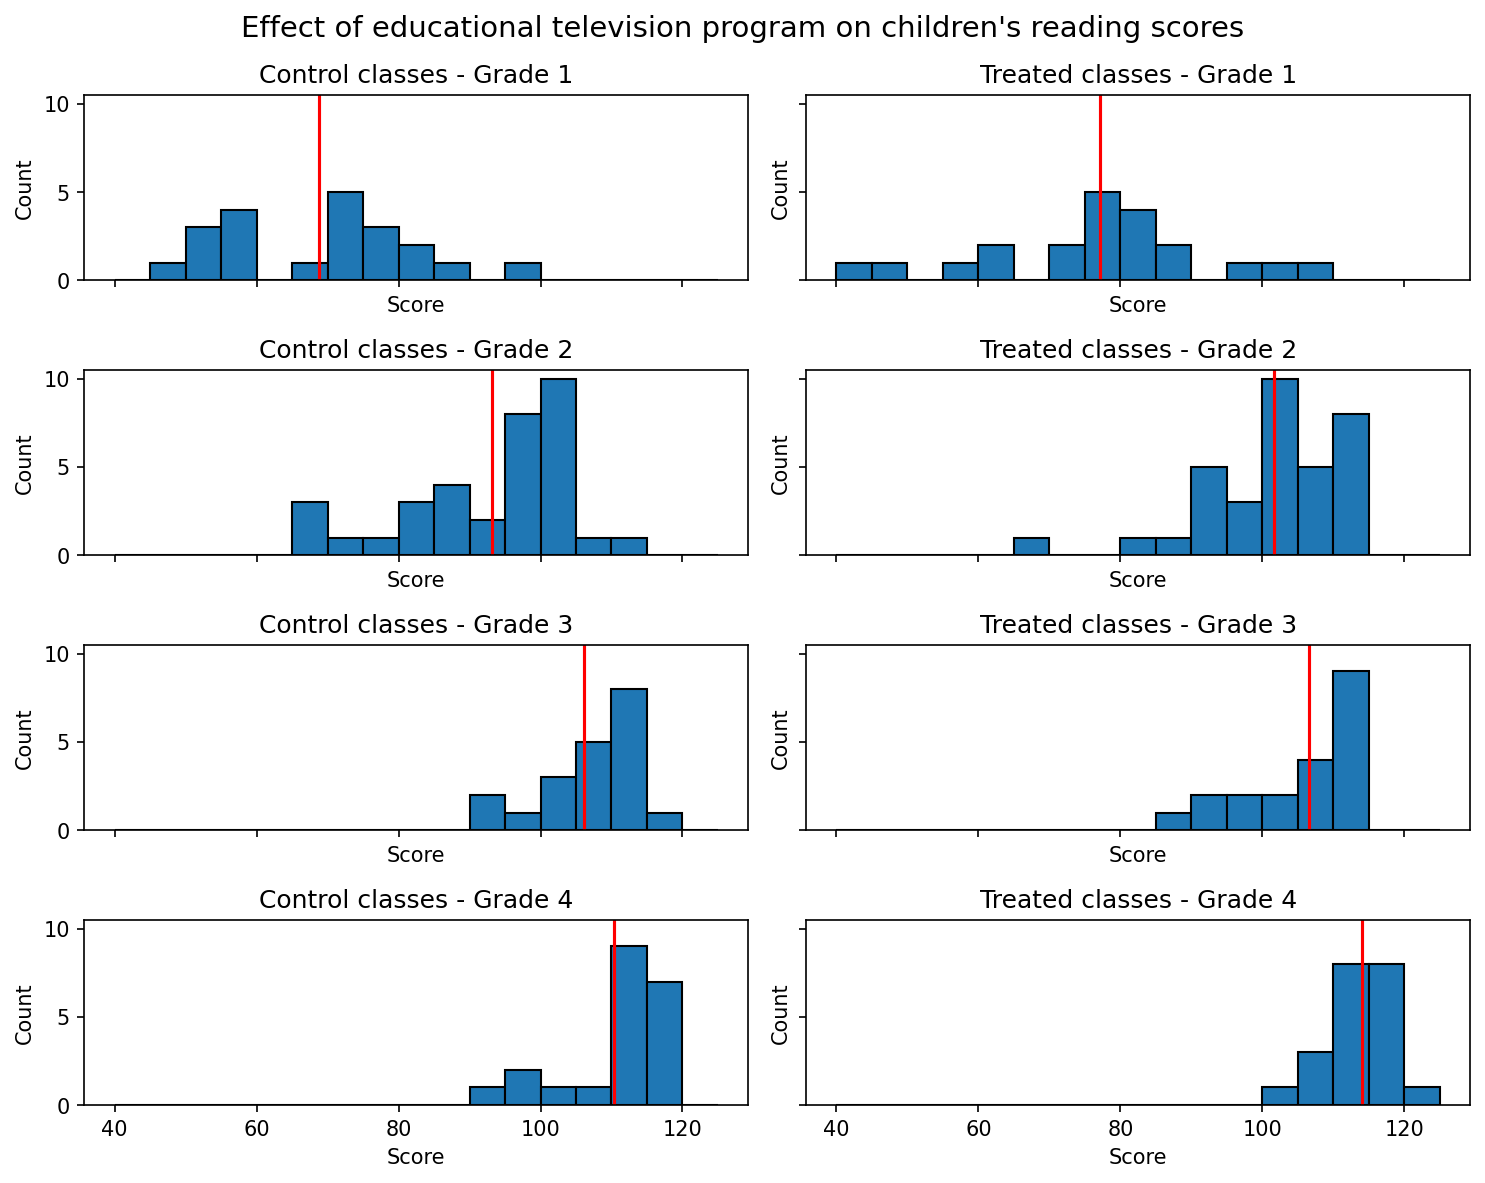

In [ ]:
import matplotlib.pyplot as plt

# Convert data from wide to long format
electric_post = pd.melt(electric_wide, id_vars='grade',
                        value_vars=['control_pretest', 'control_posttest',
                                    'treated_pretest', 'treated_posttest'],
                        var_name='group_test', value_name='score')
# Split group_test column into group and test columns
electric_post[['group', 'test']] = electric_post['group_test'].str.split('_', expand=True)

# Filter rows where test is "posttest"
electric_post = electric_post[electric_post['test'] == 'posttest']

# Calculate mean scores for each grade and group
score_means = electric_post.groupby(['grade', 'group']).mean().reset_index()

# Define grade_labels function to add labels to the grade axis
def grade_labels(x):
    return f'Grade {x}'

# Define group_labels dictionary to add labels to the group axis
group_labels = {'control': 'Control classes', 'treated': 'Treated classes'}

# Create histogram with vertical line for each group and grade combination
fig, axes = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True, figsize=(10, 8), dpi=150)
for i, grade in enumerate(sorted(electric_post['grade'].unique())):
    for j, group in enumerate(sorted(electric_post['group'].unique())):
        ax = axes[i][j]
        ax.hist(electric_post[(electric_post['grade'] == grade) & (electric_post['group'] == group)]['score'], bins=range(40, 130, 5), edgecolor='black')
        ax.axvline(x=score_means[(score_means['grade'] == grade) & (score_means['group'] == group)]['score'].values[0], color='red')
        ax.set_title(f'{group_labels[group]} - {grade_labels(grade)}', fontsize=12)
        ax.set_xlabel('Score', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)

fig.suptitle("Effect of educational television program on children's reading scores", fontsize=14)
plt.tight_layout()



### *Can we have mean/std dev in the plots? Better rendering/colors?*

In [ ]:
ELECTRIC_DATA="https://raw.githubusercontent.com/behrman/ros/master/ElectricCompany/data/electric.csv"
# Read data from file_electric_wide
electric = pd.read_csv(ELECTRIC_DATA).iloc[:, 1:]

In [ ]:
electric.head()

,post_test,pre_test,grade,treatment,supp,pair_id
0,48.9,13.8,1,1,1.0,1
1,70.5,16.5,1,1,0.0,2
2,89.7,18.5,1,1,1.0,3
3,44.2,8.8,1,1,0.0,4
4,77.5,15.3,1,1,1.0,5


## Fit linear regression on treatment indicator variable to calculate the difference in post-test averages for all grades.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression



# Set the seed for reproducibility
np.random.seed(447)

# Fit the linear regression model
X = electric['treatment'].values.reshape(-1, 1)
y = electric['post_test'].values
reg = LinearRegression().fit(X, y)

# Print the coefficients and intercept of the linear regression model
print('Coefficients: ', reg.coef_)
print('Intercept: ', reg.intercept_)


Coefficients:  [5.65729167]
Intercept:  94.32083333333335


## Separate analysis within each grade

## Regression on treatment indicator: With 95% uncertainty intervals.

Using treatment alone

In [ ]:
import bambi as bmb
import arviz as az

treatment_only_results = {} 
for grade in range(1, 5):
  model = bmb.Model(
      "post_test ~ treatment",
      data=electric.query(f"grade == {grade}"),
      categorical="treatment"
  )
  fitted = model.fit()
  summary = az.summary(fitted)
  treatment_only_results[f"Grade {grade}"] = {
    "mean": summary.loc["treatment[1]", "mean"],
    "sd": summary.loc["treatment[1]", "sd"]
  }
  

{'Grade 1': {'mean': 8.283, 'sd': 4.84}}


{'Grade 1': {'mean': 8.283, 'sd': 4.84}, 'Grade 2': {'mean': 8.331, 'sd': 2.767}}


{'Grade 1': {'mean': 8.283, 'sd': 4.84}, 'Grade 2': {'mean': 8.331, 'sd': 2.767}, 'Grade 3': {'mean': 0.285, 'sd': 2.338}}


{'Grade 1': {'mean': 8.283, 'sd': 4.84}, 'Grade 2': {'mean': 8.331, 'sd': 2.767}, 'Grade 3': {'mean': 0.285, 'sd': 2.338}, 'Grade 4': {'mean': 3.715, 'sd': 1.841}}


Z-scores for later use in calculating coefficient error bars

In [ ]:
z50 = 0.674
z95 = 1.96

Plot the coefficients along with 50 and 95% intervals when just using the treatment indicator

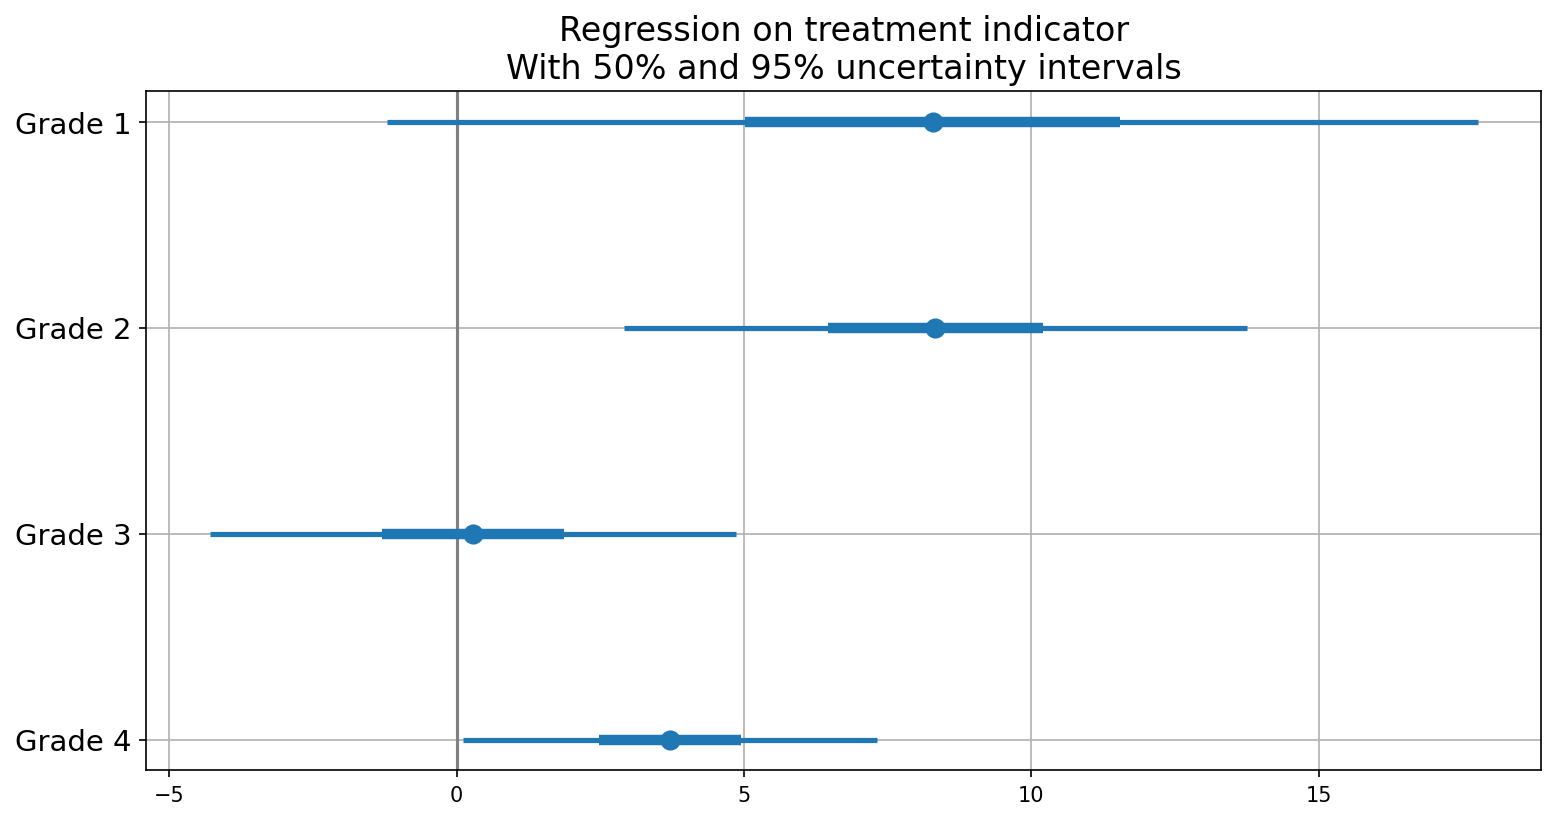

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
ax.scatter([treatment_only_results[x]['mean'] for x in treatment_only_results.keys()], treatment_only_results.keys(), s=75)
ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), color='gray')
for grade, effects in treatment_only_results.items():
  ci50 = effects['mean'] + effects['sd'] * np.array([-z50, z50])
  ci95 = effects['mean'] + effects['sd'] * np.array([-z95, z95])
  ax.hlines(y = grade, xmin=ci50[0], xmax=ci50[1], lw=5)
  ax.hlines(y = grade, xmin=ci95[0], xmax=ci95[1], lw=2.5)

ax.set_title("Regression on treatment indicator\nWith 50% and 95% uncertainty intervals", 
             fontsize=16)
plt.yticks(fontsize=14)
ax.grid(True)
ax.invert_yaxis()
fig.show()

## Adjusting for pre-test to get more precise estimates

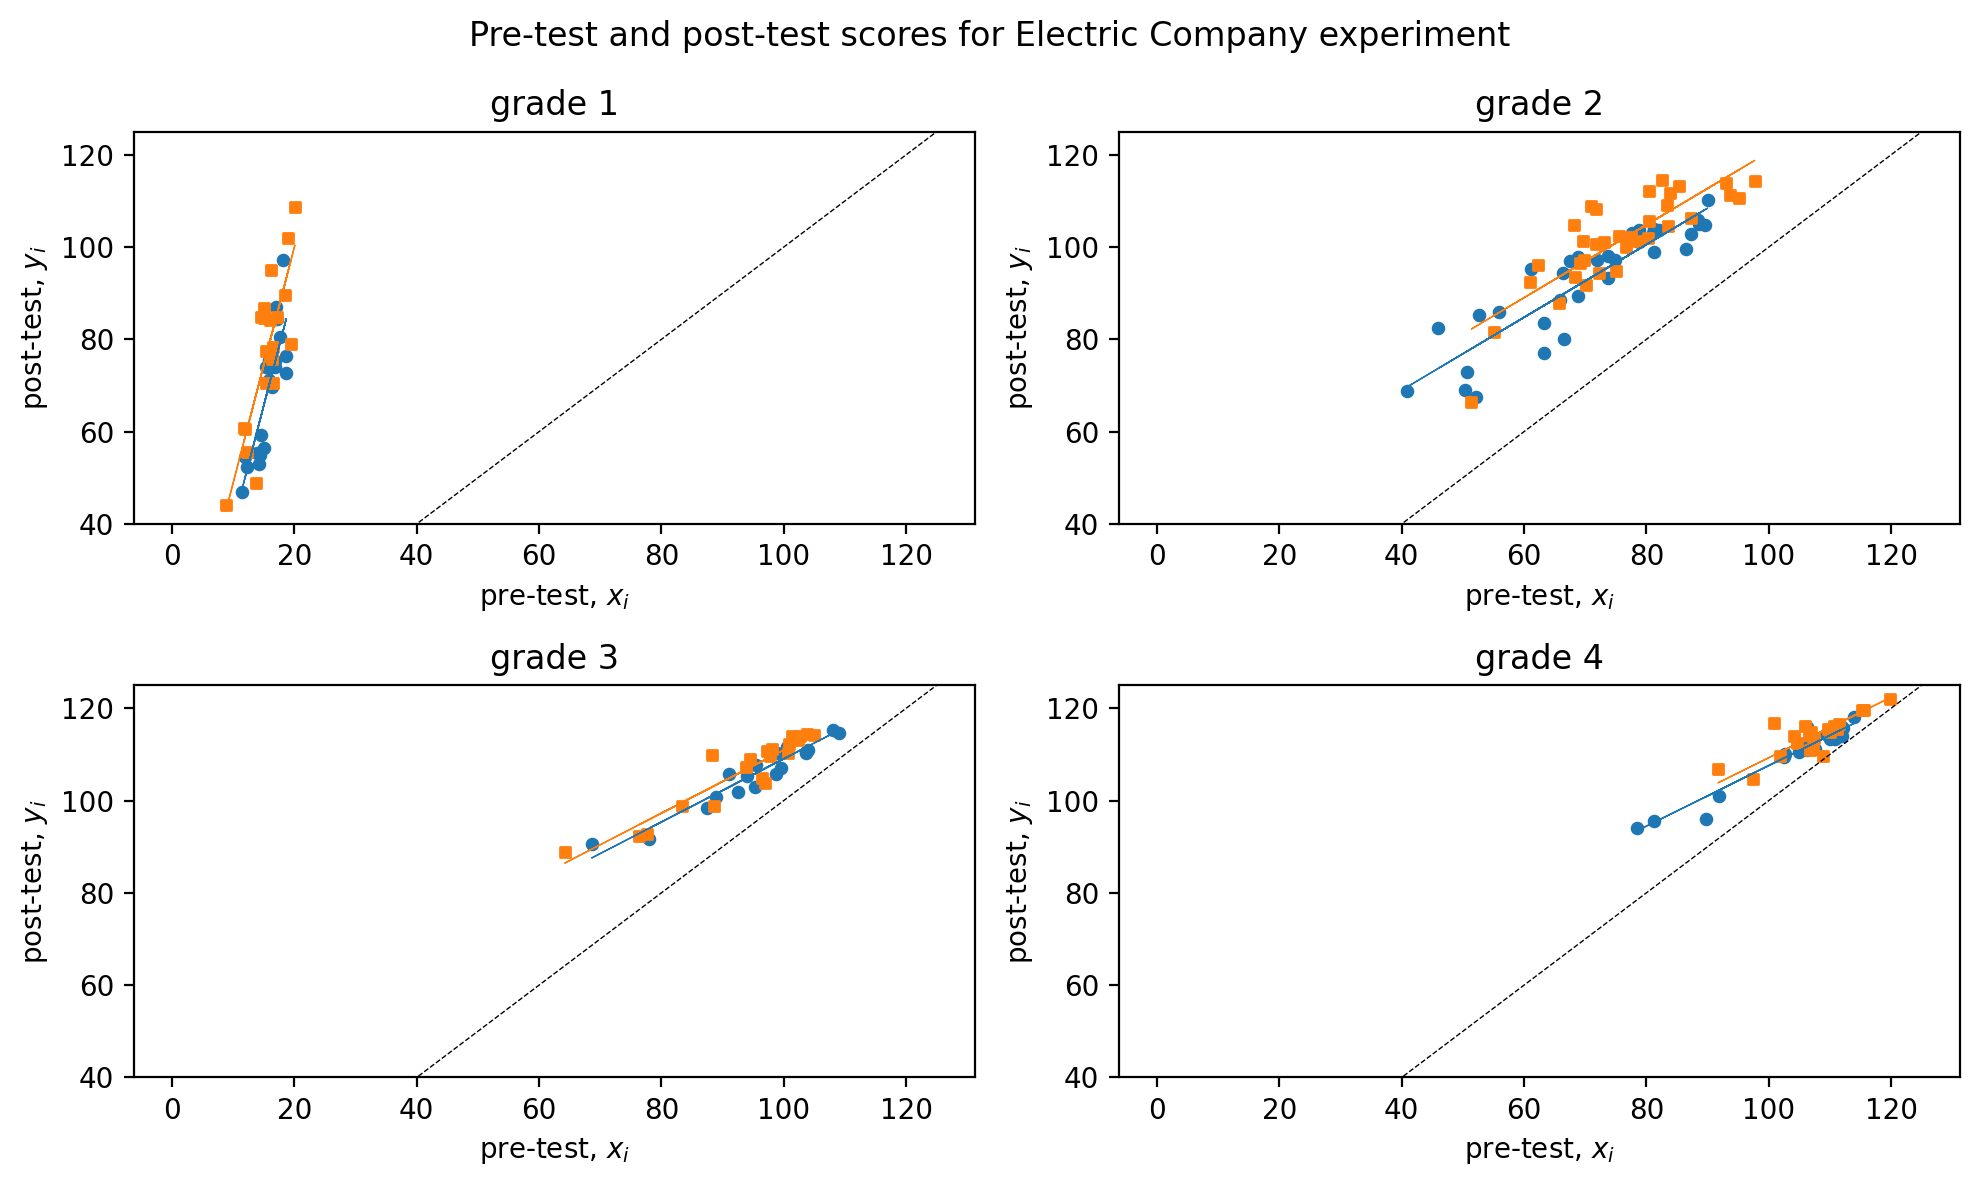

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), dpi=200)

x_ranges = np.array([[5, 40, 40, 40], [25, 125, 125, 125]])
for j in range(4):
    row_index = j // 2
    col_index = j % 2
    ok = electric['grade'] == j+1
    x = np.concatenate([electric.loc[ok & (electric['treatment'] == 1), 'pre_test'].values,
                        electric.loc[ok & (electric['treatment'] == 0), 'pre_test'].values])
    y = np.concatenate([electric.loc[ok & (electric['treatment'] == 1), 'post_test'].values,
                        electric.loc[ok & (electric['treatment'] == 0), 'post_test'].values])
    t = np.repeat([1, 0], [np.sum(ok & (electric['treatment'] == 1)), np.sum(ok & (electric['treatment'] == 0))])
    # axs[row_index, col_index].plot(x_ranges[:, j], [40, 125], 'k--', lw=0.5) #commented because this is adding another line
    axs[row_index, col_index].set_xlabel('pre-test, $x_i$')
    axs[row_index, col_index].set_ylabel('post-test, $y_i$')
    axs[row_index, col_index].set_title('grade ' + str(j+1))
    axs[row_index, col_index].scatter(electric.loc[ok & (electric['treatment'] == 0), 'pre_test'].values,
                   electric.loc[ok & (electric['treatment'] == 0), 'post_test'].values, marker='o', s=15)
    axs[row_index, col_index].scatter(electric.loc[ok & (electric['treatment'] == 1), 'pre_test'].values,
                   electric.loc[ok & (electric['treatment'] == 1), 'post_test'].values, marker='s', s=15)
    lm_1 = LinearRegression()
    lm_1.fit(np.vstack([x, t]).T, y)
    preds = lm_1.intercept_ + lm_1.coef_[0]*x + lm_1.coef_[1]*t
    axs[row_index, col_index].plot(x[t==0], preds[t==0], lw=0.5)
    axs[row_index, col_index].plot(x[t==1], preds[t==1], lw=0.5)
    axs[row_index, col_index].set_ylim(bottom=40, top=125)
    axs[row_index, col_index].plot([0, 125], [0, 125], 'k--', lw=0.5)

fig.suptitle("Pre-test and post-test scores for Electric Company experiment")
plt.tight_layout()
plt.show()


## For each grade, fit separate model with treatment, pre-test, and an interaction

In [ ]:
import bambi as bmb
import arviz as az

treatment_pretest_results = {} 
for grade in range(1, 5):
  model = bmb.Model(
      "post_test ~ treatment + pre_test",
      data=electric.query(f"grade == {grade}"),
      categorical="treatment"
  )
  fitted = model.fit()
  summary = az.summary(fitted)
  treatment_pretest_results[f"Grade {grade}"] = {
    "mean": summary.loc["treatment[1]", "mean"],
    "sd": summary.loc["treatment[1]", "sd"]
  }


{'Grade 1': {'mean': 8.846, 'sd': 2.803}}


{'Grade 1': {'mean': 8.846, 'sd': 2.803}, 'Grade 2': {'mean': 4.269, 'sd': 1.366}}


{'Grade 1': {'mean': 8.846, 'sd': 2.803}, 'Grade 2': {'mean': 4.269, 'sd': 1.366}, 'Grade 3': {'mean': 1.882, 'sd': 0.8}}


{'Grade 1': {'mean': 8.846, 'sd': 2.803}, 'Grade 2': {'mean': 4.269, 'sd': 1.366}, 'Grade 3': {'mean': 1.882, 'sd': 0.8}, 'Grade 4': {'mean': 1.707, 'sd': 0.736}}


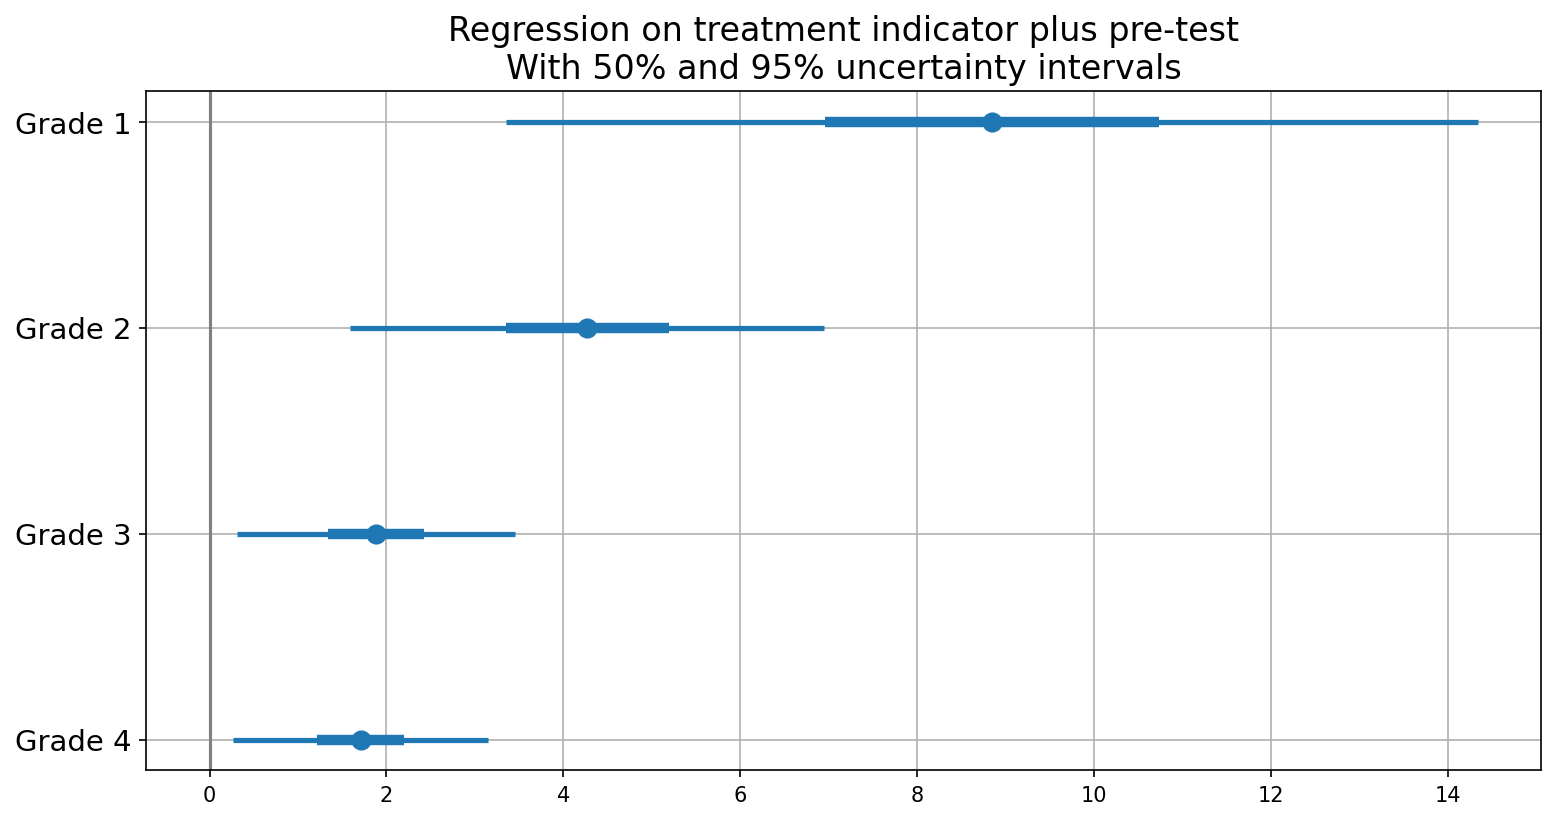

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
ax.scatter([treatment_pretest_results[x]['mean'] for x in treatment_pretest_results.keys()], treatment_pretest_results.keys(), s=75)
ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), color='gray')
for grade, effects in treatment_pretest_results.items():
  ci50 = effects['mean'] + effects['sd'] * np.array([-z50, z50])
  ci95 = effects['mean'] + effects['sd'] * np.array([-z95, z95])
  ax.hlines(y = grade, xmin=ci50[0], xmax=ci50[1], lw=5)
  ax.hlines(y = grade, xmin=ci95[0], xmax=ci95[1], lw=2.5)

ax.set_title("Regression on treatment indicator plus pre-test\nWith 50% and 95% uncertainty intervals", 
             fontsize=16)
plt.yticks(fontsize=14)
ax.grid(True)
ax.invert_yaxis()
fig.show()

## Plot Treatment Effect with Interaction

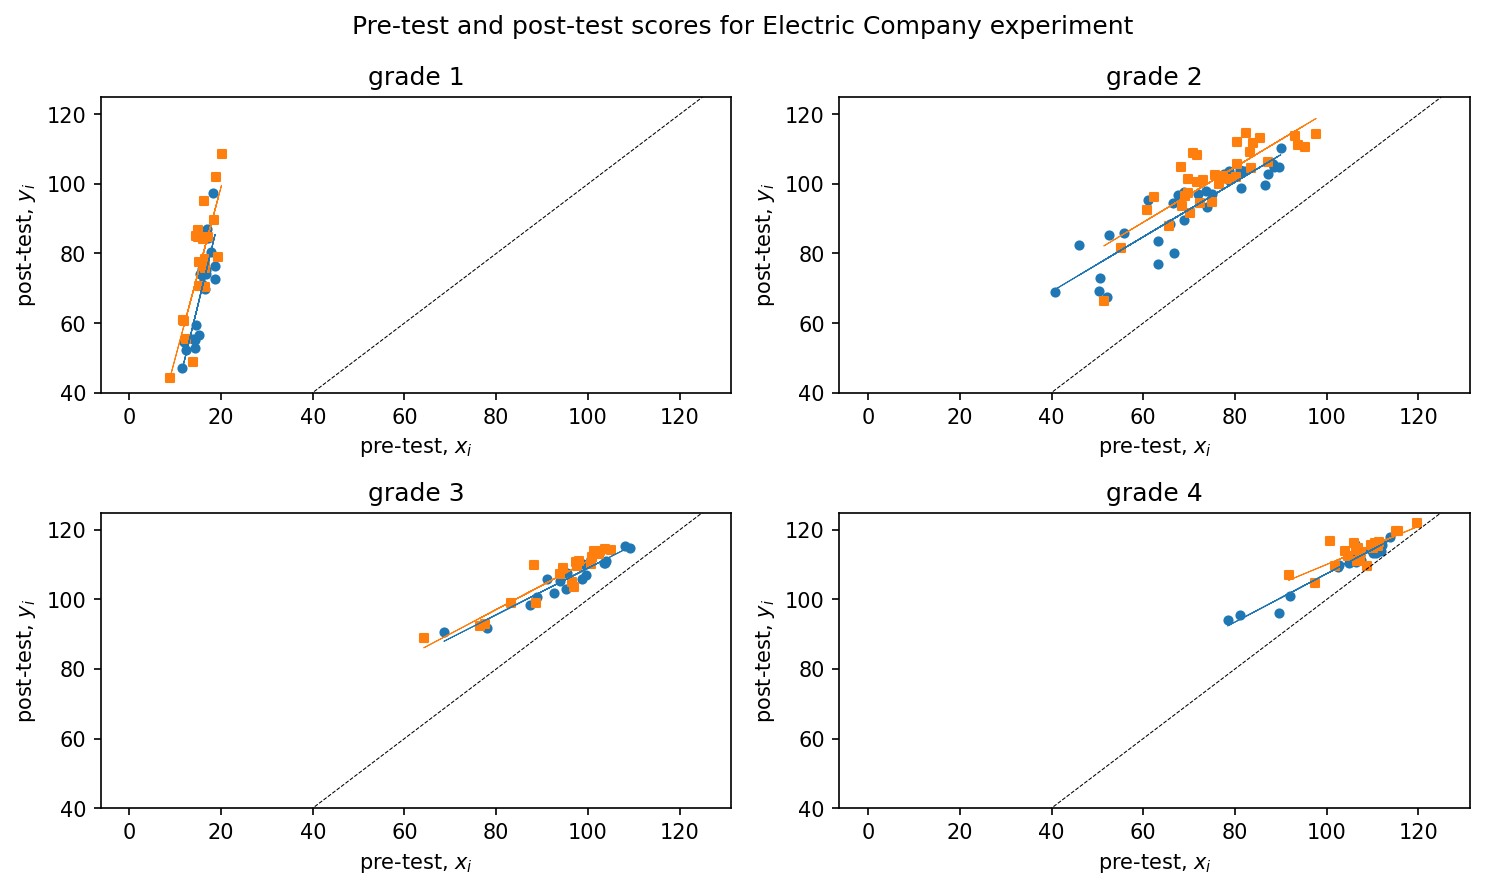

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), dpi=150)

x_ranges = np.array([[5, 40, 40, 40], [25, 125, 125, 125]])
for j in range(4):
    row_index = j // 2
    col_index = j % 2
    ok = electric['grade'] == j+1
    x = np.concatenate([electric.loc[ok & (electric['treatment'] == 1), 'pre_test'].values,
                        electric.loc[ok & (electric['treatment'] == 0), 'pre_test'].values])
    y = np.concatenate([electric.loc[ok & (electric['treatment'] == 1), 'post_test'].values,
                        electric.loc[ok & (electric['treatment'] == 0), 'post_test'].values])
    t = np.repeat([1, 0], [np.sum(ok & (electric['treatment'] == 1)), np.sum(ok & (electric['treatment'] == 0))])
    # axs[row_index, col_index].plot(x_ranges[:, j], [40, 125], 'k--', lw=0.5) #commented because this is adding another line
    axs[row_index, col_index].set_xlabel('pre-test, $x_i$')
    axs[row_index, col_index].set_ylabel('post-test, $y_i$')
    axs[row_index, col_index].set_title('grade ' + str(j+1))
    axs[row_index, col_index].scatter(electric.loc[ok & (electric['treatment'] == 0), 'pre_test'].values,
                   electric.loc[ok & (electric['treatment'] == 0), 'post_test'].values, marker='o', s=15)
    axs[row_index, col_index].scatter(electric.loc[ok & (electric['treatment'] == 1), 'pre_test'].values,
                   electric.loc[ok & (electric['treatment'] == 1), 'post_test'].values, marker='s', s=15)
    lm_2 = LinearRegression()
    lm_2.fit(np.vstack([x, t, x*t]).T, y)
    preds = lm_2.intercept_ + lm_2.coef_[0]*x + lm_2.coef_[1]*t + lm_2.coef_[2]*t*x
    axs[row_index, col_index].plot(x[t==0], preds[t==0], lw=0.5)
    axs[row_index, col_index].plot(x[t==1], preds[t==1], lw=0.5)
    axs[row_index, col_index].set_ylim(bottom=40, top=125)
    axs[row_index, col_index].plot([0, 125], [0, 125], 'k--', lw=0.5)

fig.suptitle("Pre-test and post-test scores for Electric Company experiment")
plt.tight_layout()
plt.show()


### Plot of Treatment Effect for a particular grade with 50% and 95% confidence intervals

Using the grade 4 example as in Gelman

In [ ]:
# let us get the mean and standard deviations with just treatment
print(treatment_only_results)
# with treatment and pertest 
print(treatment_pretest_results)

{'Grade 1': {'mean': 8.283, 'sd': 4.84}, 'Grade 2': {'mean': 8.331, 'sd': 2.767}, 'Grade 3': {'mean': 0.285, 'sd': 2.338}, 'Grade 4': {'mean': 3.715, 'sd': 1.841}}
{'Grade 1': {'mean': 8.846, 'sd': 2.803}, 'Grade 2': {'mean': 4.269, 'sd': 1.366}, 'Grade 3': {'mean': 1.882, 'sd': 0.8}, 'Grade 4': {'mean': 1.707, 'sd': 0.736}}


In [ ]:
interaction_lm = bmb.Model(
    "post_test ~ pre_test + treatment + pre_test*treatment",
    data=electric.query("grade == 4"),
    categorical='treatment', auto_scale=False,
)

interaction_results = interaction_lm.fit()

In [ ]:
result_df = interaction_results.to_dataframe(groups="posterior")
result_df.head()

,chain,draw,Intercept,pre_test,"(treatment[0], 1)","(pre_test:treatment[0], 1)",post_test_sigma
0,0,0,30.307876,0.757410,38.565552,-0.338217,1.979988
1,0,1,30.694256,0.762245,35.026792,-0.315059,2.026635
2,0,2,32.544350,0.738417,34.168973,-0.291464,2.076917
3,0,3,35.084891,0.707842,39.945403,-0.333692,2.704377
4,0,4,28.665948,0.786270,40.733335,-0.375781,2.834437


Create a linear interpolation between the min and max observed pre-test scores, and get the treatment effect for each point. The result will be `# points X # of samples`, so we'll aggregate by taking the quantiles over the sample axis to produce intervals. The final result will be an array of `[90 lower, 50 lower, 50 upper, 90 upper]` for each example pre-test score

In [ ]:
points = np.linspace(electric.query("grade == 4")['pre_test'].min(), electric.query("grade == 4")['pre_test'].max(), num=201)
plot_data = np.quantile(result_df[('treatment[0]', '1')].values + result_df[('pre_test:treatment[0]', '1')].values * points[:, None], 
                        [0.05, 0.25, 0.75, 0.95], 
                        axis=1)
plot_data.shape

(4, 201)

Now get the average treatment effect for every pre-test score

In [ ]:
coef_df = az.summary(interaction_results)
coef_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,37.938,4.786,29.623,47.152,0.139,0.098,1190.0,1281.0,1.0
pre_test,0.695,0.046,0.608,0.776,0.001,0.001,1187.0,1261.0,1.0
treatment[1],17.351,9.924,-1.222,35.509,0.331,0.248,901.0,602.0,1.0
pre_test:treatment[1],-0.147,0.093,-0.318,0.025,0.003,0.002,895.0,687.0,1.0
post_test_sigma,2.088,0.219,1.682,2.494,0.006,0.005,1121.0,1103.0,1.0


In [ ]:
avg_line = points * coef_df.loc["pre_test:treatment[1]", 'mean'] + coef_df.loc['treatment[1]', 'mean']

Plot the treatment effects and intervals

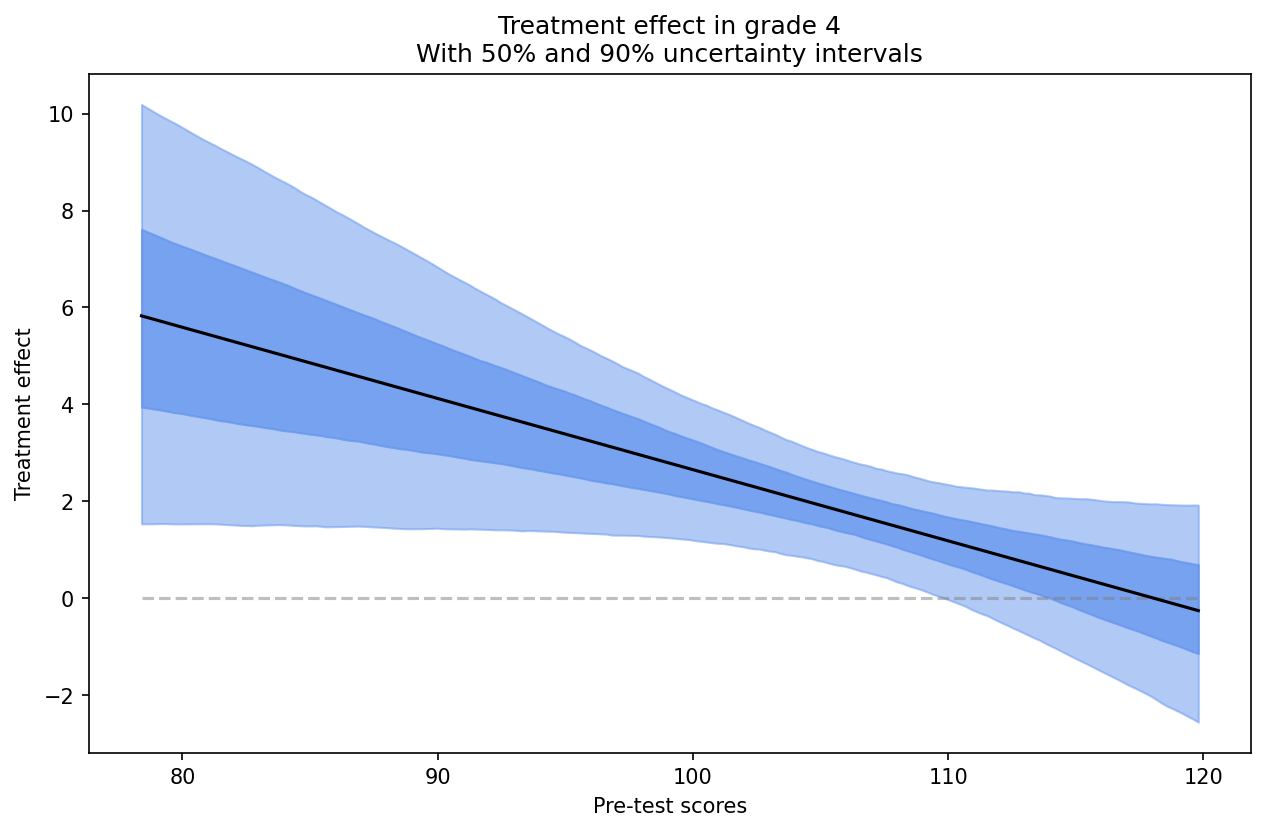

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hlines(y=0, xmin=points[0], xmax=points[-1], color='gray', alpha=0.5, ls='dashed')
plt.fill_between(points, plot_data[0, :], plot_data[3, :], alpha=0.5, color="cornflowerblue")
plt.fill_between(points, plot_data[1, :], plot_data[2, :], alpha=0.75, color="cornflowerblue")
plt.plot(points, avg_line, color='black')
plt.title("Treatment effect in grade 4\nWith 50% and 90% uncertainty intervals")
plt.xlabel("Pre-test scores")
plt.ylabel("Treatment effect")
plt.show()

## Estimate the effect of supplement, as compared to the replacement, per grade

Fit a GLM for each grade indicating the impact of supplemental treatment vs. replacement

In [ ]:
supp_results = {} 
for grade in range(1, 5):
  model = bmb.Model(
      "post_test ~ pre_test + supp",
      data=electric.query(f"grade == {grade} & ~supp.isna()"),
      categorical="supp"
  )
  fitted = model.fit()
  summary = az.summary(fitted)
  supp_results[f"Grade {grade}"] = {
    "mean": summary.loc["supp[1.0]", "mean"],
    "sd": summary.loc["supp[1.0]", "sd"]
  }
print(supp_results)

{'Grade 1': {'mean': 6.001, 'sd': 4.854}, 'Grade 2': {'mean': 4.646, 'sd': 1.915}, 'Grade 3': {'mean': -1.293, 'sd': 1.679}, 'Grade 4': {'mean': -0.351, 'sd': 1.239}}


Plot the results

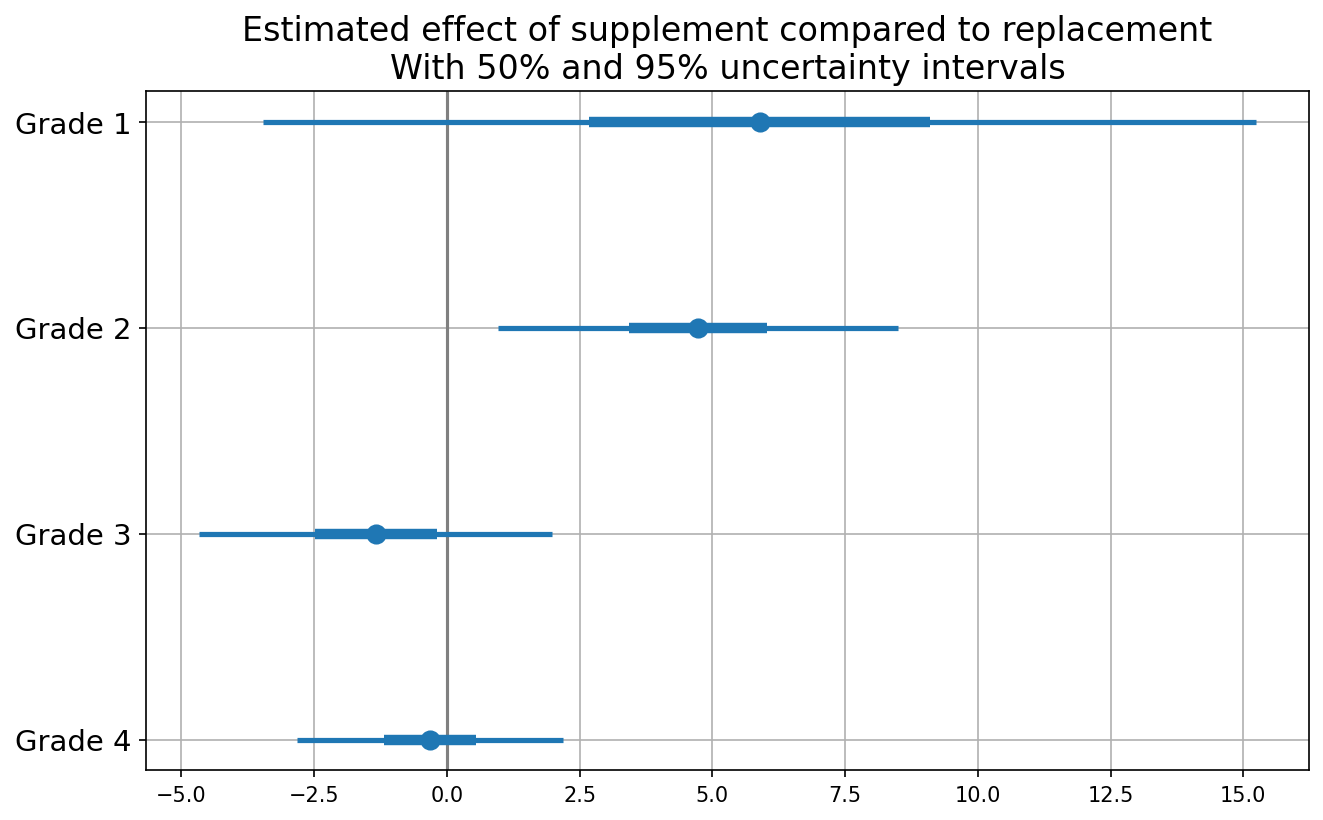

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.scatter([supp_results[x]['mean'] for x in supp_results.keys()], supp_results.keys(), s=75)
ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), color='gray')
for grade, effects in supp_results.items():
  ci50 = effects['mean'] + effects['sd'] * np.array([-z50, z50])
  ci95 = effects['mean'] + effects['sd'] * np.array([-z95, z95])
  ax.hlines(y = grade, xmin=ci50[0], xmax=ci50[1], lw=5)
  ax.hlines(y = grade, xmin=ci95[0], xmax=ci95[1], lw=2.5)

ax.set_title("Estimated effect of supplement compared to replacement\nWith 50% and 95% uncertainty intervals", 
             fontsize=16)
plt.yticks(fontsize=14)
ax.grid(True)
ax.invert_yaxis()
fig.show()